In [1]:
import pandas as pd
from plotnine import *
from plotnine.data import *
from tabulate import tabulate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
import numpy as np

dsNames = ["education","football","military","politics","tv_and_film"]
largeSampleDF = pd.DataFrame()
for dsName in dsNames:
    df = pd.read_csv("localData/semanticAnnotation/largeFilesCorrectDecay/"+dsName + ".csv")
    largeSampleDF = largeSampleDF.append(df)
print(largeSampleDF.columns)
print(len(largeSampleDF.index))


largeSampleDF["[0.0,0.7) (<70%)"] = largeSampleDF['compatibilityPercentageNoDecay'] < 0.7
largeSampleDF["[0.7,1.0) (70%)"] = ((largeSampleDF['compatibilityPercentageNoDecay'] >= 0.7) & (largeSampleDF['compatibilityPercentageNoDecay'] < 1.0))
largeSampleDF["[1.0,1.0] (full)"] = largeSampleDF['compatibilityPercentageNoDecay'] == 1.0

bucketNames = ["[0.0,0.7) (<70%)","[0.7,1.0) (70%)","[1.0,1.0] (full)"]
bucketAndDatasetToWeight = {}
bucketToWeight = {}
for bucketName in bucketNames:
    for dsName in dsNames:
        thisDF = largeSampleDF[largeSampleDF['dataset']==dsName]
        share = sum(thisDF[bucketName]) / len(thisDF.index)
        bucketAndDatasetToWeight[(dsName,bucketName)]=share
    share = sum(largeSampleDF[bucketName]) / len(largeSampleDF.index)
    bucketToWeight[bucketName] = share
        #print(dsName,bucketName, share)
#Relative Sizes of the three buckets:
print(bucketAndDatasetToWeight)
print(bucketToWeight)
# finalDF["isIn100PercentBucketWithFilter"] = ( (finalDF['compatibilityPercentageNoDecay'] ==1.0) & (finalDF["hasTransitionOverlapDecay"]))
# finalDF["isIn70PercentBucket"] = ( (finalDF['compatibilityPercentageNoDecay'] >=0.7) & (finalDF["hasTransitionOverlapDecay"]))
#
# scoreNames = ["isInExactMatchBlocking","isInSequenceBlocking","isInValueSetBlocking",
#               "isInStrictBlockingNoDecay","isIn70PercentBucket","isIn100PercentBucket",
#               "isIn100PercentBucketWithFilter","isIn70PercentBucket"]
# for bucketName in scoreNames:
#     rr = sum(finalDF[bucketName]) / len(finalDF.index)
#     print(bucketName, rr)

/tmp/ipykernel_111120/1355704925.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_111120/1355704925.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_111120/1355704925.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_111120/1355704925.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_111120/1355704925.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Index(['dataset', 'id1', 'id2', 'isInStrictBlockingDecay',
       'isInStrictBlockingNoDecay', 'isInValueSetBlocking',
       'isInSequenceBlocking', 'isInExactMatchBlocking', 'isSemanticRoleMatch',
       'compatibilityPercentageDecay', 'compatibilityPercentageNoDecay',
       'exactSequenceMatchPercentage', 'hasTransitionOverlapNoDecay',
       'hasTransitionOverlapDecay', 'hasValueSetOverlap',
       'isInSVABlockingNoDecay', 'isInSVABlockingDecay', 'VACount', 'DVACount',
       'isInTSMBlockingNoWildcard', 'isInTSMBlockingWithWildcard',
       'strictlyCompatiblePercentage'],
      dtype='object')
50000
{('education', '[0.0,0.7) (<70%)'): 0.1709, ('football', '[0.0,0.7) (<70%)'): 0.3128, ('military', '[0.0,0.7) (<70%)'): 0.0602, ('politics', '[0.0,0.7) (<70%)'): 0.0943, ('tv_and_film', '[0.0,0.7) (<70%)'): 0.2466, ('education', '[0.7,1.0) (70%)'): 0.702, ('football', '[0.7,1.0) (70%)'): 0.6492, ('military', '[0.7,1.0) (70%)'): 0.7591, ('politics', '[0.7,1.0) (70%)'): 0.7285, ('tv_a

In [2]:
import role_matching.EvaluationHelperMethods as rm

#df = pd.read_csv("localData/semanticAnnotation/results.csv")
OLD=True # old or new gold standard

if(OLD):
    df = pd.read_csv("localData/semanticAnnotation/gs1/results.csv")
else:
    df = pd.read_csv("localData/semanticAnnotation/gs2/results.csv")
df['isInCBRB'] = ((df['compatibilityPercentageDecay'] >=0.8))
df['isInCBRBNoDecay'] = ((df['compatibilityPercentageNoDecay'] >=0.8))
df['isInCBRBWithTransitionFilter'] = ((df['compatibilityPercentageDecay'] >=0.8) & df['hasTransitionOverlapDecay'])
df['isInCBRBNoDecayWithTransitionFilter'] = ((df['compatibilityPercentageNoDecay'] >=0.8) & df['hasTransitionOverlapNoDecay'])
df['isInStrictBlockingDecayWithTransitionFilter'] = ((df['compatibilityPercentageDecay'] >=1.0) & df['hasTransitionOverlapDecay'])
df['isInStrictBlockingNoDecayWithTransitionFilter'] = ((df['compatibilityPercentageNoDecay'] >=1.0) & df['hasTransitionOverlapNoDecay'])
df['isInStrictCompatibleBlocking'] = (df['strictlyCompatiblePercentage'] >= 1.0)
#filters:

rm.addFilteredBlockingMethods(df)




#TODO about the filtering! Currently we are not applying the transition filters to CBRB and CBRB NoDecay but the table in the paper does - we need to choose what we want to represent in the final matrix

print(df.dtypes)

datasetToAbbreviation = {
'austintexas' : 'AU',
'chicago' : 'CH',
'gov.maryland' : 'MD',
'oregon' : 'OR',
'utah' : 'UT',
'education' : 'ED',
'football' : 'FO',
'military' : 'MI',
'politics' : 'PO',
'tv_and_film' : 'TV'
}




df['bucket'] = df['compatibilityPercentageNoDecay'].map(lambda x: rm.getGroup(x))
for bucket in df['bucket'].unique():
    print(bucket,sum((df['isSemanticRoleMatch']) & (df['bucket']==bucket)))

df["weight"] = df.apply(lambda x: rm.getWeight(bucketAndDatasetToWeight,x),axis=1)

print(df["weight"])
#print(df.describe())
# plot = ggplot(df,aes(x = 'isSemanticRoleMatch',fill="dataset",group='dataset')) + geom_histogram(position=position_dodge()) + theme(axis_text_x = element_text(angle=90, hjust=1))
# print(plot)
# plot = ggplot(df,aes(x = 'compatibilityPercentageDecay',fill="dataset")) + geom_histogram(position=position_dodge())
# print(plot)

# for dsName in df.dataset.unique():
#     thisDF = df[df['dataset']==dsName]
#     print(dsName,"Positive Rate: ", sum(thisDF['isSemanticRoleMatch']) / len(thisDF.index) )
#     print(dsName,"Positive Counts/Rate in Compatible (with Decay): ",sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingDecay']), "/", sum(thisDF['isInStrictBlockingDecay']),sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingDecay']) / sum(thisDF['isInStrictBlockingDecay']) )
#
#     print(dsName,"Counts/Percentage of Semantic Being Compatible (with Decay): ",sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingDecay']),"/",sum(thisDF['isSemanticRoleMatch']), sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingDecay']) / sum(thisDF['isSemanticRoleMatch']) )
#     print(dsName,"Positive Counts/Rate in Compatible (without Decay): ",sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingNoDecay']),"/",sum(thisDF['isInStrictBlockingNoDecay']), sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingNoDecay']) / sum(thisDF['isInStrictBlockingNoDecay']) )
#     print(dsName,"Counts/Percentage of Semantic Being Compatible (without Decay): ",sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingNoDecay']),"/",sum(thisDF['isSemanticRoleMatch']), sum(thisDF['isSemanticRoleMatch'] & thisDF['isInStrictBlockingNoDecay']) / sum(thisDF['isSemanticRoleMatch']) )

dataset                                           object
id1                                               object
id2                                               object
isInStrictBlockingDecay                             bool
isInStrictBlockingNoDecay                           bool
isInValueSetBlocking                                bool
isInSequenceBlocking                                bool
isInExactMatchBlocking                              bool
isSemanticRoleMatch                                 bool
compatibilityPercentageDecay                     float64
compatibilityPercentageNoDecay                   float64
exactSequenceMatchPercentage                     float64
hasTransitionOverlapNoDecay                         bool
hasTransitionOverlapDecay                           bool
hasValueSetOverlap                                  bool
isInSVABlockingNoDecay                              bool
isInSVABlockingDecay                                bool
VACount                        

In [3]:
rm.addDVA2VA95Blocking(df)
print(len(df[~df['isInDVA2VA95Blocking']].index))
print(len(df[df['isInDVA2VA95Blocking']].index))
print(df[(~df['isInDVA2VA95Blocking']) & df['isSemanticRoleMatch']])

819
681
          dataset                                                id1  \
2     tv_and_film      infobox film||36439749||502437794-0||based on   
107   tv_and_film   infobox television||2594309||30694549-0||creator   
445     education      infobox university||381909||45798676-0||state   
470     education      infobox uk school||16557266||261883145-0||lea   
954      politics  infobox_president||165217||65391157-0||success...   
1002     politics  infobox election||10459794||206442907-0||previ...   
1047     politics  infobox_politician||51613||59932236-0||predece...   
1112     politics  infobox election||11100973||270697276-0||previ...   
1113     politics     infobox election||40509||150171511-0||nominee1   
1174     politics   infobox_president||339513||67869722-0||term_end2   
1181     politics  infobox_president||2006306||34527379-0||term_s...   
1255     military      infobox weapon||11446814||178219904-0||origin   
1346     military  infobox military conflict||20474118||

In [4]:
print(df[(df['isSemanticRoleMatch']) & (df['bucket']=="[0.7,1.0) (70%)")]["compatibilityPercentageNoDecay"])

2       0.998563
129     0.992816
165     0.982759
246     0.923851
299     0.989943
407     0.887931
445     0.964080
765     0.909483
800     0.903736
898     0.850575
921     0.977011
927     0.837644
949     0.925287
997     0.830460
1002    0.992816
1153    0.985632
1161    0.820402
1255    0.966954
1382    0.737069
1416    0.981322
1421    0.735632
Name: compatibilityPercentageNoDecay, dtype: float64


# Precision / Recall / F1

In [5]:
import role_matching.MetricHelperMethods as mhm

if(OLD):
    weighted = False
else:
    weighted = True
methodNames = ['isInExactMatchBlocking','isInSequenceBlocking','isInValueSetBlocking','isInStrictBlockingNoDecay','isInTSMBlockingNoWildcard','isInTSMBlockingWithWildcard','isInStrictCompatibleBlocking']
               #'isInExactMatchBlockingWithFilter','isInSequenceBlockingWithFilter','isInValueSetBlockingWithFilter','isInStrictBlockingNoDecayWithFilter']

#print("dataset","#TP","EM,,","CSM,,","VSM,,","RM,,","FCBRM (ND),,","FCBRM (D),,","CBRM (ND),,","CBRM (D),,",sep=",")
print("dataset","#TP","EM,,","CSM,,","VSM,,","FCBRM (ND),,","TSM (NWC),,","TSM (WC),,","SCB ,,","EM (WF),,","CSM (WF),,","VSM (WF),,","FCBRM (NDWF),,",sep=",")
print("," + (",P,R,F1"* (len(methodNames))))
#print(",,P,R,F1","P,R,F1","P,R,F1","P,R,F1","P,R,F1",sep=",")
dsNameList = []
for dsName in df['dataset'].unique():
    dsNameList.append(dsName)
dsNameList.sort()
for dsName in dsNameList:
    shortName = datasetToAbbreviation[dsName]
    mhm.printPostiveRateForNonparametrizedMethodsDF(shortName,df[df['dataset']==dsName],methodNames,weighted,bucketAndDatasetToWeight)
mhm.printPostiveRateForNonparametrizedMethodsDF("Micro-AVG",df,methodNames,weighted,bucketAndDatasetToWeight)
mhm.printMacroAverages("Macro-AVG",df,methodNames,weighted,bucketAndDatasetToWeight)
print("----------------------------------------------------------------------------------------------------")

dataset,#TP,EM,,,CSM,,,VSM,,,FCBRM (ND),,,TSM (NWC),,,TSM (WC),,,SCB ,,,EM (WF),,,CSM (WF),,,VSM (WF),,,FCBRM (NDWF),,
,,P,R,F1,P,R,F1,P,R,F1,P,R,F1,P,R,F1,P,R,F1,P,R,F1
ED,21,25,42, 32,17,61, 27,17,76, 28,17,80, 28,17,76, 29,22,61, 32,19,76, 30
FO,49,47,87, 61,45,89, 60,43,93, 59,46,93, 61,44,91, 60,46,89, 61,46,91, 62
MI,21,12,23, 16,9,33, 14,7,33, 11,12,57, 19,7,33, 12,10,33, 15,7,33, 12
PO,34,25,47, 32,22,55, 31,21,64, 32,21,61, 31,21,61, 32,22,55, 32,21,55, 30
TV,37,36,40, 38,30,67, 41,29,75, 42,29,78, 42,30,75, 43,30,64, 41,31,72, 43
Micro-AVG,162,32,54, 40,26,66, 37,24,73, 36,25,77, 37,24,72, 36,27,66, 39,25,70, 37
Macro-AVG,,29,48,36,25,61,35,23,68,34,25,74,36,24,67,35,26,61,36,25,66,35,----------------------------------------------------------------------------------------------------


In [32]:
#
#Returned number of pairs vs Recall:
print("dataset","#TP","EM,","CSM,","VSM,","FCBRM (ND),","FCBRM (NDWF),",sep=",")
print(",,N,R","N,R","N,R","N,R","N,R",sep=",")
methods = ['isInExactMatchBlocking','isInSequenceBlocking','isInValueSetBlocking','isInStrictBlockingNoDecay','isInStrictBlockingNoDecayWithFilter']
dsNameList = []
for dsName in df['dataset'].unique():
    dsNameList.append(dsName)
dsNameList.sort()
for dsName in dsNameList:
    shortName = datasetToAbbreviation[dsName]
    mhm.printNAndRecallForNonparametrizedMethodsDF(shortName,df[df['dataset']==dsName],methods)
mhm.printNAndRecallForNonparametrizedMethodsDF("Micro-AVG",df,methods)
mhm.printMacroAveragesNAndRecall("Macro-AVG",df,methods)

dataset,#TP,EM,,CSM,,VSM,,FCBRM (ND),,FCBRM (NDWF),
,,N,R,N,R,N,R,N,R,N,R
ED,22,31,72,88,90,129,90,100,81,90,72
FO,8,19,100,71,100,103,100,100,100,93,87
MI,21,4,14,69,38,117,57,100,66,86,66
PO,33,51,51,117,81,149,87,100,84,79,84
TV,58,20,13,84,77,135,98,100,91,88,91
Micro-AVG,142,125,36,429,76,633,88,500,85,436,83
Macro-AVG,,50,25,77,85,86,126,84,100,80,87,

# Tabular Overview over True Semantic Matches

In [33]:
# true positives:
dfTruePositivesOnly = df[df['isSemanticRoleMatch']]
tab = dfTruePositivesOnly.groupby(['dataset','bucket']).size()
print(tab)

dataset      bucket          
education    [0.0,0.7) (<70%)     1
             [0.7,1.0) (70%)      3
             [1.0,1.0] (full)    18
football     [1.0,1.0] (full)     8
military     [0.0,0.7) (<70%)     7
             [1.0,1.0] (full)    14
politics     [0.0,0.7) (<70%)     1
             [0.7,1.0) (70%)      4
             [1.0,1.0] (full)    28
tv_and_film  [0.7,1.0) (70%)      5
             [1.0,1.0] (full)    53
dtype: int64


# Tabular Overview over True Semantic Matches Sorted by Compatibility

In [34]:
dfTruePositives = df[df['isSemanticRoleMatch']]
#For Decay:
dfTruePositives.sort_values('compatibilityPercentageDecay',inplace=True)
print(tabulate(dfTruePositives, headers='keys', tablefmt='psql'))
#Total:
print(sum(df['isSemanticRoleMatch']))
print(sum(df['isSemanticRoleMatch'] & df['isInStrictBlockingDecay']))
# For No Decay:
dfTruePositives.sort_values('compatibilityPercentageNoDecay',inplace=True)
print(tabulate(dfTruePositives, headers='keys', tablefmt='psql'))
#Total:
print(sum(df['isSemanticRoleMatch']))
print(sum(df['isSemanticRoleMatch'] & df['isInStrictBlockingNoDecay']))


+------+-------------+----------------------------------------------------------------------------+---------------------------------------------------------------------------------+---------------------------+-----------------------------+------------------------+------------------------+--------------------------+-----------------------+--------------------------------+----------------------------------+--------------------------------+-------------------------------+-----------------------------+----------------------+--------------------------+------------------------+-----------+------------+------------+-------------------+--------------------------------+---------------------------------------+-----------------------------------------------+-------------------------------------------------+---------------------------------------+----------------------------------+----------------------------------+------------------------------------+------------------+----------+----------------

/tmp/ipykernel_6994/945213557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_6994/945213557.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Recall Plots

No Single true role match for below (with decay)  0.3127690100430416 found in  33 elements
No Single true role match for below (with decay)  0.3735632183908046 found in  8 elements
No Single true role match for below (without decay)  0.3649425287356322 found in  14 elements


/tmp/ipykernel_6994/444426828.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


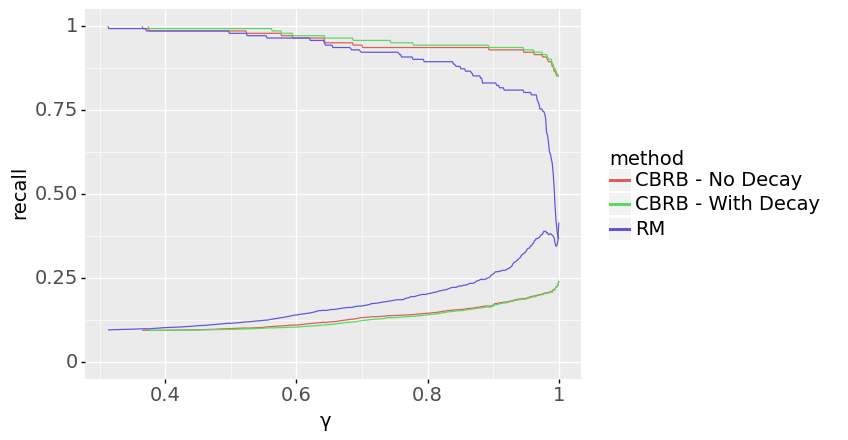

/tmp/ipykernel_6994/444426828.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_6994/444426828.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_6994/444426828.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_6994/444426828.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_6994/444426828.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


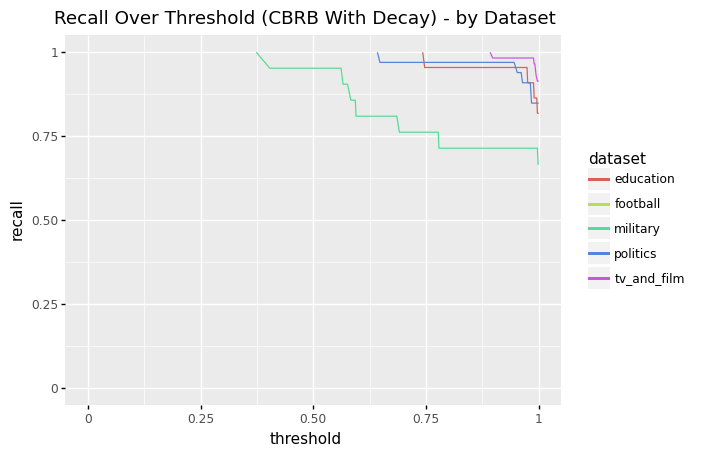

/tmp/ipykernel_6994/444426828.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


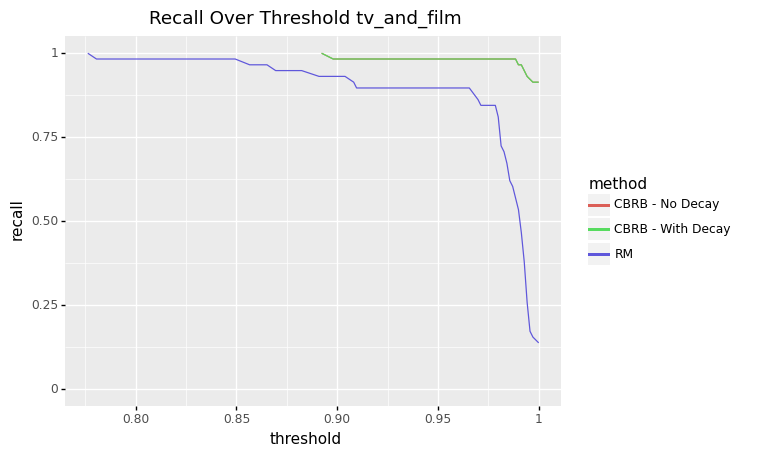

/tmp/ipykernel_6994/444426828.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


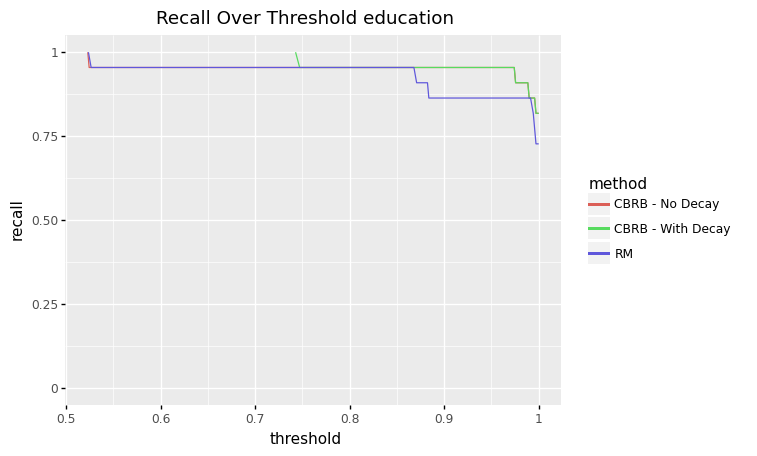

/tmp/ipykernel_6994/444426828.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


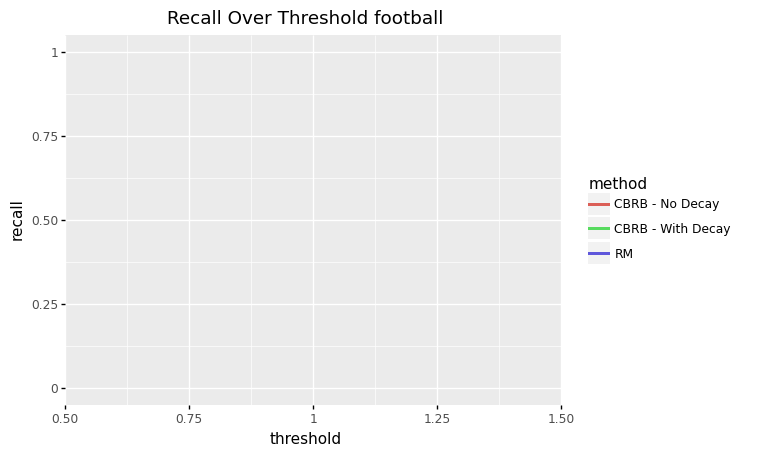

/tmp/ipykernel_6994/444426828.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


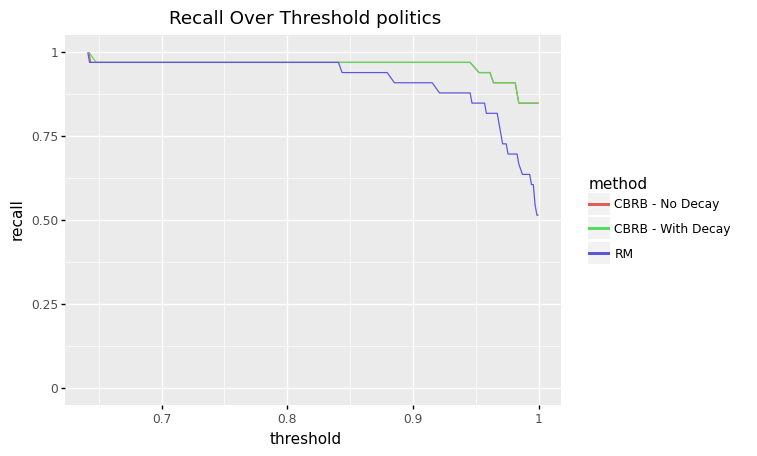

/tmp/ipykernel_6994/444426828.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


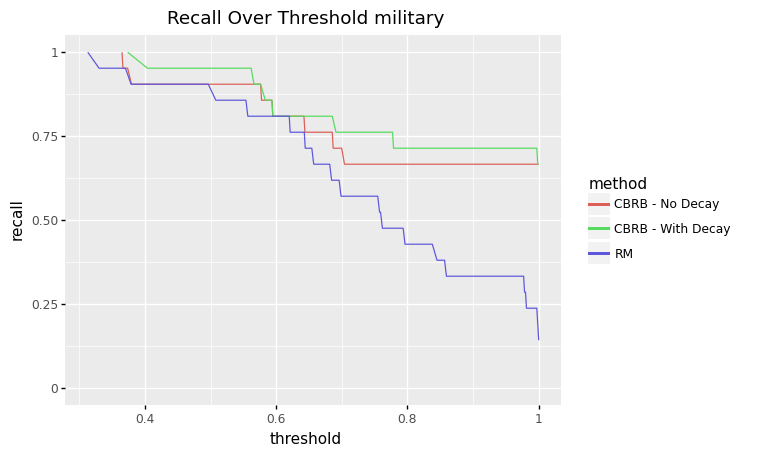

In [35]:
#exact match:
precision,recall,threshold = precision_recall_curve(df['isSemanticRoleMatch'],df['exactSequenceMatchPercentage'])
lowestThreshold = threshold[0]
relaxedMatchRecallDf = df[df['exactSequenceMatchPercentage']<lowestThreshold]
print("No Single true role match for below (with decay) ",lowestThreshold,"found in ",len(relaxedMatchRecallDf.index),"elements")
plotDFRelaxedExactMatch = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"RM", 'precision':precision[0:len(precision)-1]})

#no decay:
precision,recall,threshold = precision_recall_curve(df['isSemanticRoleMatch'],df['compatibilityPercentageDecay'])
lowestThreshold = threshold[0]
noRecallDf = df[df['compatibilityPercentageDecay']<lowestThreshold]
print("No Single true role match for below (with decay) ",lowestThreshold,"found in ",len(noRecallDf.index),"elements")
plotDFVA = pd.DataFrame({'recall': recall[0:len(recall) - 1], 'threshold':threshold, "method": "CBRB - With Decay", 'precision': precision[0:len(precision) - 1]})
#decay:
precision,recall,threshold = precision_recall_curve(df['isSemanticRoleMatch'],df['compatibilityPercentageNoDecay'])
lowestThreshold = threshold[0]
noRecallDf = df[df['compatibilityPercentageNoDecay']<lowestThreshold]
print("No Single true role match for below (without decay) ",lowestThreshold,"found in ",len(noRecallDf.index),"elements")
plotDF2 = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"CBRB - No Decay", 'precision':precision[0:len(precision)-1]})
finalPlotDF = plotDFVA.append(plotDF2).append(plotDFRelaxedExactMatch)
plot = ggplot(finalPlotDF,aes(x = 'threshold',y='recall',color="method",group="method")) + geom_line() + ylim(0, 1) + xlab("γ") + theme(text=element_text(size=14)) + geom_line(finalPlotDF,aes(x = 'threshold',y='precision',group="method",color="method"))#+ ggtitle("Recall on GOld Standard - all Datasets Combined")
print(plot)
#for every dataset:

largeSampleDF = pd.DataFrame()
for ds in df.dataset.unique():
    thisDF = df[df['dataset']==ds]
    precision,recall,threshold = precision_recall_curve(thisDF['isSemanticRoleMatch'],thisDF['compatibilityPercentageDecay'])
    plotDFVA = pd.DataFrame({'recall': recall[0:len(recall) - 1], 'threshold':threshold, 'dataset':ds, 'precision': precision[0:len(precision) - 1]})
    largeSampleDF = largeSampleDF.append(plotDFVA)
plot = ggplot(largeSampleDF, aes(x ='threshold', y='recall', group="dataset", color="dataset")) + geom_line() + xlim(0, 1) + ylim(0, 1) + ggtitle("Recall Over Threshold (CBRB With Decay) - by Dataset")
print(plot)

# For every dataset:
for ds in df.dataset.unique():
    thisDF = df[df['dataset']==ds]
    #exactMatch:
    precision,recall,threshold = precision_recall_curve(thisDF['isSemanticRoleMatch'],thisDF['exactSequenceMatchPercentage'])
    plotDFRelaxedExactMatch = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"RM"})
    #decay:
    precision,recall,threshold = precision_recall_curve(thisDF['isSemanticRoleMatch'],thisDF['compatibilityPercentageDecay'])
    plotDFVA = pd.DataFrame({'recall': recall[0:len(recall) - 1], 'threshold':threshold, "method": "CBRB - With Decay"})
    #no decay:
    precision,recall,threshold = precision_recall_curve(thisDF['isSemanticRoleMatch'],thisDF['compatibilityPercentageNoDecay'])
    plotDF2 = pd.DataFrame({'recall': recall[0:len(recall)-1], 'threshold':threshold,"method":"CBRB - No Decay"})
    finalPlotDF = plotDFVA.append(plotDF2).append(plotDFRelaxedExactMatch)
    plot = ggplot(finalPlotDF,aes(x = 'threshold',y='recall',color="method",group="method")) + geom_line() + ylim(0, 1) + ggtitle("Recall Over Threshold " + ds)
    print(plot)



# Beta-Gamma Tradeoff

In [24]:
dfBetaGamma = pd.read_csv("localData/semanticAnnotation/gamma_beta_relationship.csv")
#dfBetaGamma = pd.read_csv("localData/semanticAnnotation/gamma_beta_relationship_laterTrainTimeEnd.csv")
print(dfBetaGamma.columns)
print(dfBetaGamma.dtypes)
dfBetaGamma['bucket'] = dfBetaGamma['actualCompatibilityNoDecay'].map(lambda x: getGroup(x)) #actualCompatibilityNoDecay

#TODO: add bucket here somehow - not sure if and how that makes sense!

# for ds in dfBetaGamma['dataset'].unique():
#     dsForThisDS = dfBetaGamma[dfBetaGamma['dataset']==ds]
#     dsShort = datasetToAbbreviation[ds]
#     plot = ggplot(df,aes(x = 'gamma',y='beta',fill="dataset",group='dataset')) + geom_histogram(position=position_dodge()) + theme(axis_text_x = element_text(angle=90, hjust=1))


Index(['dataset', 'id1', 'id2', 'betaThreshold', 'gammaThreshold', 'isInCBRB',
       'isSemanticRoleMatch', 'actualCompatibilityNoDecay',
       'strictlyCompatiblePercentage',
       'actualStrictlyCompatiblePercentageNoDecay', 'isInSCB'],
      dtype='object')
dataset                                       object
id1                                           object
id2                                           object
betaThreshold                                float64
gammaThreshold                               float64
isInCBRB                                        bool
isSemanticRoleMatch                             bool
actualCompatibilityNoDecay                   float64
strictlyCompatiblePercentage                 float64
actualStrictlyCompatiblePercentageNoDecay    float64
isInSCB                                         bool
dtype: object


# For FCBRB

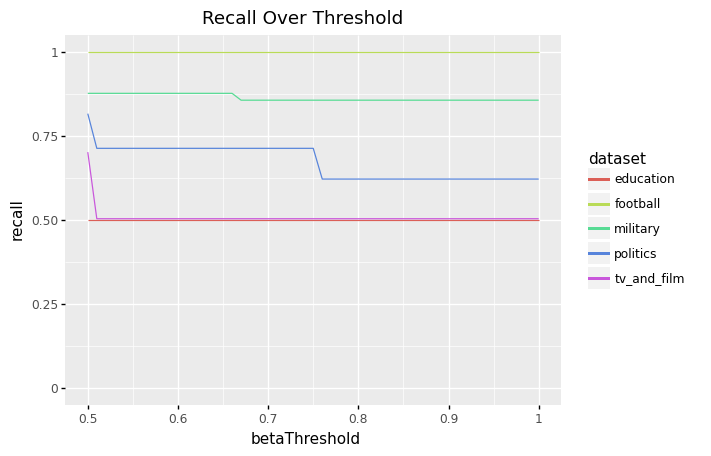

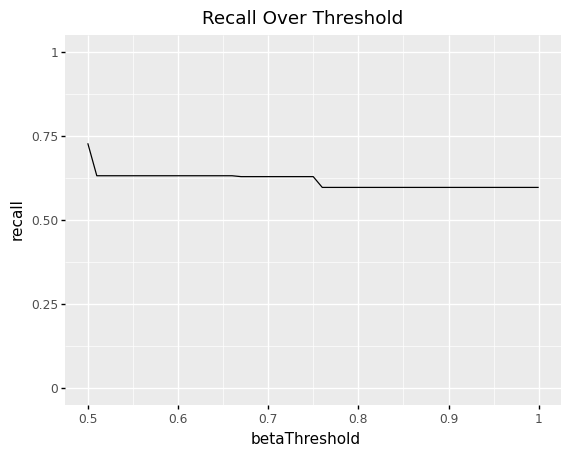

In [38]:
finalDFNoRelaxation = largeSampleDF[largeSampleDF['gammaThreshold'] == 1.0]
#By Dataset:
plot = ggplot(finalDFNoRelaxation,aes(x = 'betaThreshold',y='recall',color="dataset",group="dataset")) + geom_line() + ylim(0, 1) + ggtitle("Recall Over Threshold ")
print(plot)
#All:
finalDFNoRelaxationAll = finalDFWithoutDatasetInGrouping[finalDFWithoutDatasetInGrouping['gammaThreshold']==1.0]
plot = ggplot(finalDFNoRelaxationAll,aes(x = 'betaThreshold',y='recall')) + geom_line() + ylim(0, 1) + ggtitle("Recall Over Threshold ")
print(plot)

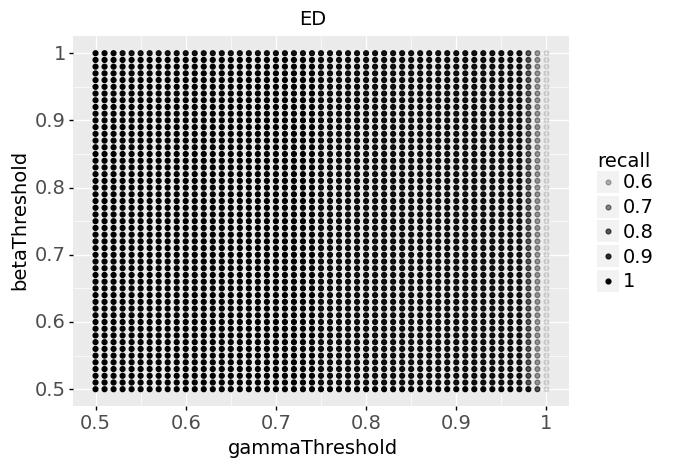

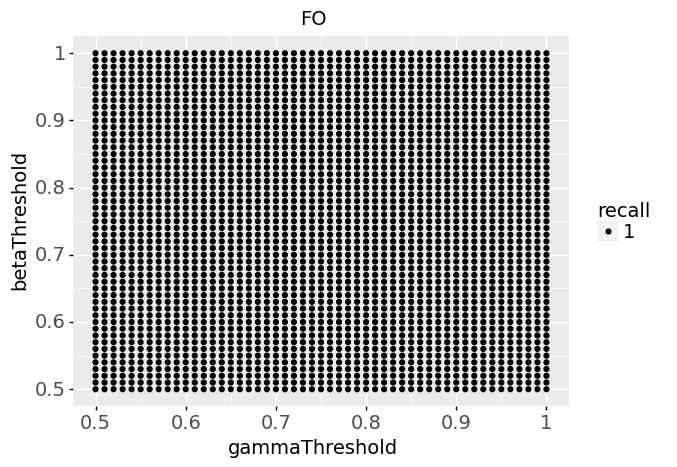

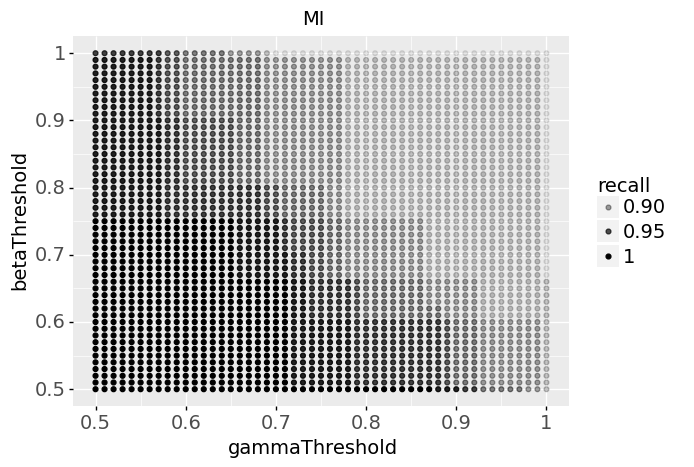

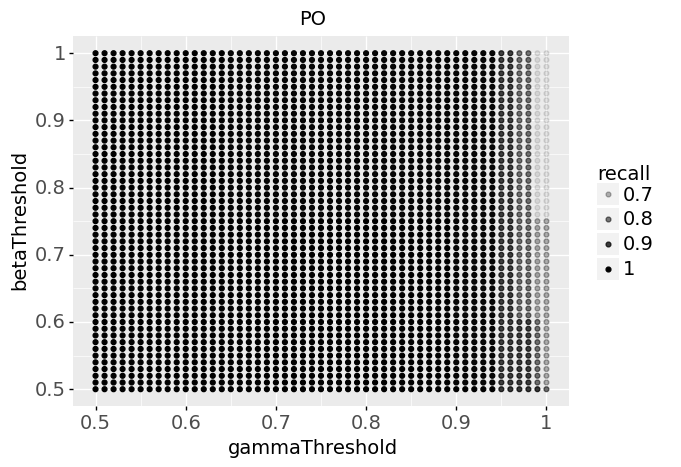

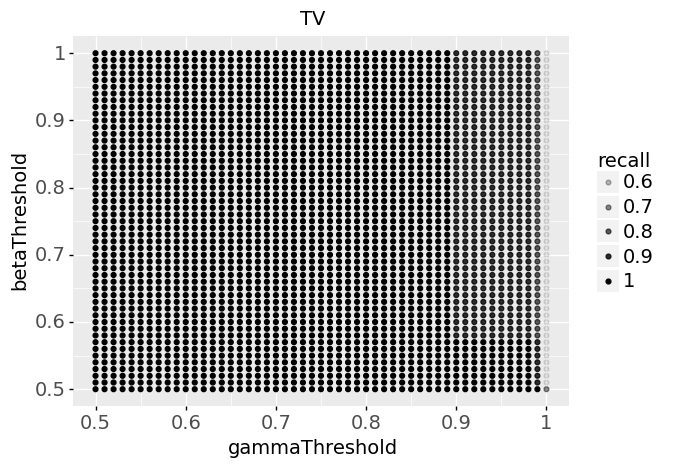

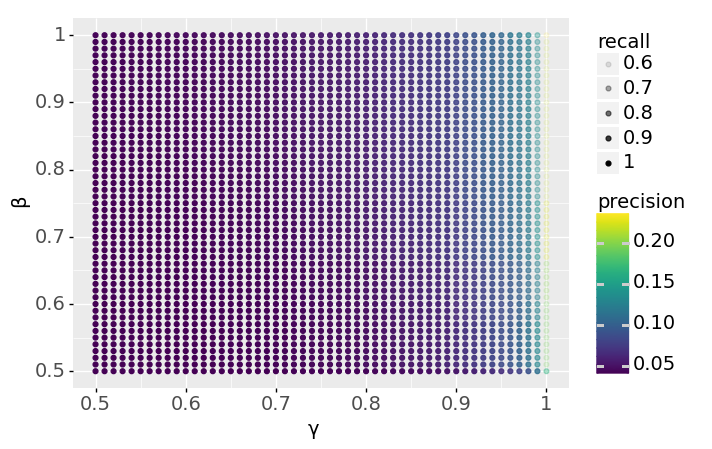

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/gammaBetaImpact_Recall.png


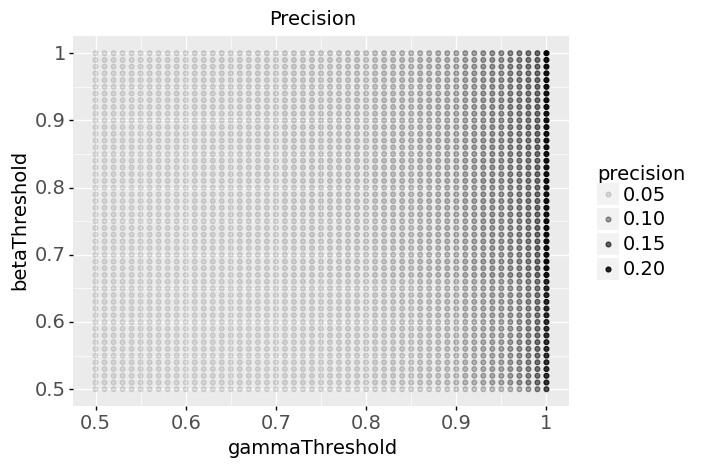

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/gammaBetaImpact_Precision.png


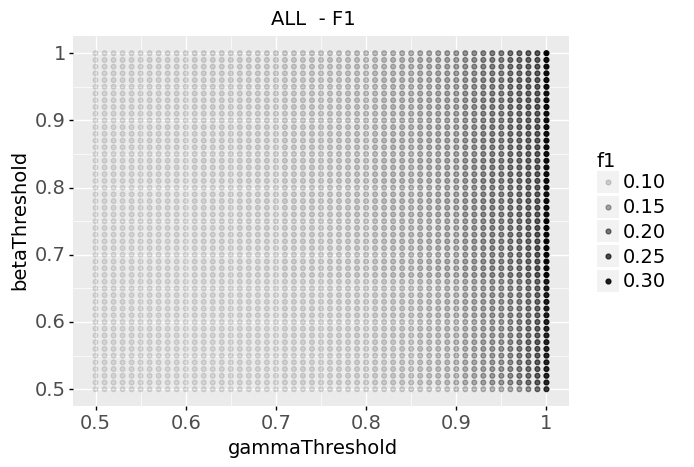

In [39]:

for ds in largeSampleDF['dataset'].unique():
    dsForThisDS = largeSampleDF[largeSampleDF['dataset'] == ds]
    dsShort = datasetToAbbreviation[ds]
    plot = ggplot(dsForThisDS,aes(x = 'gammaThreshold',y='betaThreshold',alpha="recall")) + geom_point() + xlim(0.5,1) + ylim(0.5,1) + ggtitle(dsShort) + theme(text=element_text(size=14))#+ theme(axis_text_x = element_text(angle=90, hjust=1))
    print(plot)
#for all
plot = ggplot(finalDFWithoutDatasetInGrouping,aes(x = 'gammaThreshold',y='betaThreshold',alpha="recall",color='precision')) +xlab("γ") + ylab("β") + geom_point() + xlim(0.5,1) + ylim(0.5,1) + theme(text=element_text(size=14)) #+ theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)
plot.save("exportedPlots/gammaBetaImpact_Recall.png")
plot = ggplot(finalDFWithoutDatasetInGrouping,aes(x = 'gammaThreshold',y='betaThreshold',alpha="precision")) + geom_point() + xlim(0.5,1) + ylim(0.5,1) + ggtitle("Precision")+ theme(text=element_text(size=14))#+ theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)
plot.save("exportedPlots/gammaBetaImpact_Precision.png")
plot = ggplot(finalDFWithoutDatasetInGrouping,aes(x = 'gammaThreshold',y='betaThreshold',alpha="f1")) + geom_point() + xlim(0.5,1) + ylim(0.5,1) + ggtitle("ALL  - F1") + theme(text=element_text(size=14))#+ theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)

# Decay Curve for 0.8

      betaThreshold  gammaThreshold  precision    recall        f1
30             0.50             0.8   0.048268  1.000000  0.092091
81             0.51             0.8   0.051711  0.987181  0.098275
132            0.52             0.8   0.051711  0.987181  0.098275
183            0.53             0.8   0.051711  0.987181  0.098275
234            0.54             0.8   0.051741  0.987181  0.098328
285            0.55             0.8   0.051852  0.987181  0.098529
336            0.56             0.8   0.052010  0.987181  0.098814
387            0.57             0.8   0.052010  0.987181  0.098814
438            0.58             0.8   0.052533  0.987181  0.099758
489            0.59             0.8   0.052583  0.987181  0.099848
540            0.60             0.8   0.052583  0.987181  0.099848
591            0.61             0.8   0.053044  0.981883  0.100650
642            0.62             0.8   0.053044  0.981883  0.100650
693            0.63             0.8   0.053332  0.981883  0.10

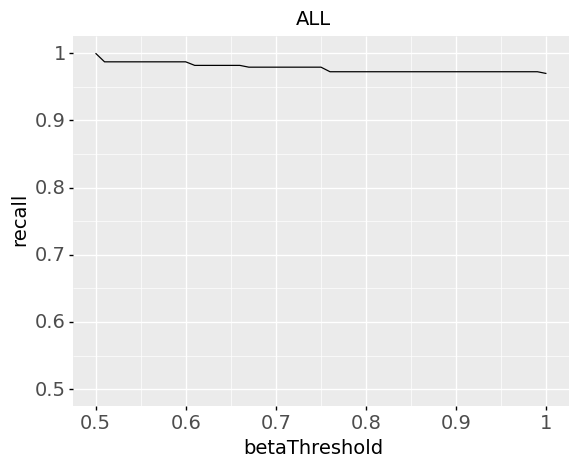

In [40]:
#All:

decayCurveDF = finalDFWithoutDatasetInGrouping[finalDFWithoutDatasetInGrouping['gammaThreshold']==0.8]
pd.set_option('display.max_rows', 500)
print(decayCurveDF)
pd.reset_option('display.max_rows')
plot = ggplot(decayCurveDF,aes(x = 'betaThreshold',y='recall')) + geom_line() + xlim(0.5,1) + ylim(0.5,1) + ggtitle("ALL") + theme(text=element_text(size=14))#+ theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)

In [25]:
rows = []
grouped = dfBetaGamma.groupby(['dataset', 'betaThreshold', 'gammaThreshold'])
for (dataset,betaThreshold,gammaThreshold),group in grouped:
    precision,recall,f1 = getWEIGHTEDPRF("isInCBRB",group)
    rows.append({"dataset":dataset, "betaThreshold":betaThreshold, "gammaThreshold":gammaThreshold, "precision":precision, "recall":recall, "f1":f1})
largeSampleDF = pd.DataFrame(rows)

rowsWithoutDatasetInGrouping = []
groupedWithoutDataset = dfBetaGamma.groupby(['betaThreshold','gammaThreshold'])
for (betaThreshold,gammaThreshold),group in groupedWithoutDataset:
    precision,recall,f1 = getWEIGHTEDPRF("isInCBRB",group)
    rowsWithoutDatasetInGrouping.append({"method":"isInCBRB","betaThreshold":betaThreshold, "gammaThreshold":gammaThreshold, "precision":precision, "recall":recall, "f1":f1})
    precision,recall,f1 = getWEIGHTEDPRF("isInSCB",group)
    rowsWithoutDatasetInGrouping.append({"method":"isInSCB","betaThreshold":betaThreshold, "gammaThreshold":gammaThreshold, "precision":precision, "recall":recall, "f1":f1})
finalDFWithoutDatasetInGrouping = pd.DataFrame(rowsWithoutDatasetInGrouping)


# Target Recall - All

[1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9, 0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8, 0.79, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7, 0.69, 0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6, 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5, 0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.32, 0.31, 0.3, 0.29, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23, 0.22, 0.21, 0.2, 0.19, 0.18, 0.17, 0.16, 0.15, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]


/tmp/ipykernel_98698/3070458578.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_98698/3070458578.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_98698/3070458578.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_98698/3070458578.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

    recall  gammaCBRB (D)  betaCBRB (D)  gammaSCB (D)  betaSCB (D)  \
0     1.00           0.87          0.50          0.52         0.50   
1     0.99           0.92          0.50          0.75         0.50   
2     0.98           0.94          0.50          0.74         0.66   
3     0.97           0.94          0.56          0.87         0.50   
4     0.96           0.94          0.57          0.89         0.50   
5     0.95           0.94          0.57          0.93         0.50   
6     0.94           0.97          0.56          0.93         0.56   
7     0.93           0.94          1.00          0.94         0.55   
8     0.92           0.94          1.00          0.94         0.55   
9     0.91           0.98          0.57          0.96         0.50   
10    0.90           0.96          1.00          0.96         0.55   
11    0.89           0.96          1.00          0.96         0.55   
12    0.88           0.96          1.00          0.96         0.55   
13    0.87          

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/prCurve.png


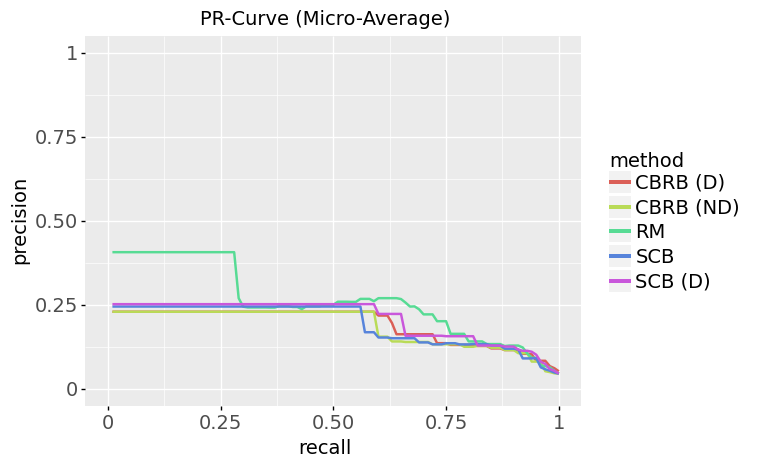

In [26]:
#All:
targetRecallThresholds = []
for i in range(0,100):
    targetRecallThresholds.append((100 - i)/100)
print(targetRecallThresholds)

dsRows = []
configRows = []

WEIGHTED = True

for targetRecall in targetRecallThresholds:
    precisonCBRBWithDecay,precisionRowCBRB = mhm.getPrecisionForTargetRecall(finalDFWithoutDatasetInGrouping, targetRecall,"isInCBRB")
    dsRows.append({"method":"CBRB (D)","targetRecall":targetRecall,"precision":precisonCBRBWithDecay})
    precisonSCBWithDecay,precisionRowSCB = mhm.getPrecisionForTargetRecall(finalDFWithoutDatasetInGrouping, targetRecall,"isInSCB")
    dsRows.append({"method":"SCB (D)","targetRecall":targetRecall,"precision":precisonSCBWithDecay})
    precisionCBRBNoDecay,gammaThresholdCBRBNoDecay = mhm.getPrecisionForTargetRecallForMethod(df,targetRecall,"compatibilityPercentageNoDecay",WEIGHTED)
    dsRows.append({"method":"CBRB (ND)","targetRecall":targetRecall,"precision":precisionCBRBNoDecay})
    precisionRM,gammaThresholdRM = mhm.getPrecisionForTargetRecallForMethod(df,targetRecall,"exactSequenceMatchPercentage",WEIGHTED)
    dsRows.append({"method":"RM","targetRecall":targetRecall,"precision":precisionRM})
    precisionSCB,gammaThresholdSCB = mhm.getPrecisionForTargetRecallForMethod(df,targetRecall,"strictlyCompatiblePercentage",WEIGHTED)
    dsRows.append({"method":"SCB","targetRecall":targetRecall,"precision":precisionSCB})
    configRows.append({"recall":targetRecall,
                       "gammaCBRB (D)":precisionRowCBRB['gammaThreshold'],
                       "betaCBRB (D)":precisionRowCBRB['betaThreshold'],
                       "gammaSCB (D)":precisionRowSCB['gammaThreshold'],
                       "betaSCB (D)":precisionRowSCB['betaThreshold'],
                       "gamma CBRB (ND)":gammaThresholdCBRBNoDecay,
                       "gamma RM":gammaThresholdRM,
                       "gamma SCB":gammaThresholdSCB})

configDF = pd.DataFrame(configRows)



pd.set_option('display.max_rows', 500)
print(configDF)

plotDFVA = pd.DataFrame(dsRows)
plot = ggplot(plotDFVA, aes(x ='targetRecall', y='precision', group="method", color ="method")) + geom_line(size=1) + xlim(0, 1) + ylim(0, 1) + ggtitle("PR-Curve (Micro-Average)") + theme(text=element_text(size=14)) + xlab("recall")#+ theme(axis_text_x = element_text(angle=90, hjust=1))
plot.save("exportedPlots/prCurve.png")
print(plot)

# targetRecall=0.85

# printBestPrecisionAtTargetRecall("ALL",finalDFWithoutDatasetInGrouping,targetRecall)
#
# #For every Dataset:
# for ds in finalDF['dataset'].unique():
#     dsForThisDS = finalDF[finalDF['dataset']==ds]
#     printBestPrecisionAtTargetRecall(ds,dsForThisDS,targetRecall)
#
# best precision for RM:


# Target Recall - By Dataset

In [13]:
for ds in largeSampleDF['dataset'].unique():
    dsForThisDS = largeSampleDF[largeSampleDF['dataset'] == ds]
    dsShort = datasetToAbbreviation[ds]
    normalDfForThisDS = df[df['dataset']==ds]
    dsRows = []
    for targetRecall in targetRecallThresholds:
        precisonCBRBWithDecay,thresholdCBRBDecay = getPrecisionForTargetRecall(dsForThisDS, targetRecall)
        dsRows.append({"dataset":ds,"method":"CBRB (D)","targetRecall":targetRecall,"precision":precisonCBRBWithDecay})
        #precisionCBRBNoDecay,thresholdCBRBNoDecay = getPrecisionForTargetRecallForMethod(normalDfForThisDS,targetRecall,"compatibilityPercentageNoDecay")
        #dsRows.append({"method":"CBRB (ND)","targetRecall":targetRecall,"precision":precisionCBRBNoDecay})
        precisionRM,thresholdRM = getPrecisionForTargetRecallForMethod(normalDfForThisDS,targetRecall,"exactSequenceMatchPercentage")
        dsRows.append({"dataset":ds,"method":"RM","targetRecall":targetRecall,"precision":precisionRM})
    plotDFVA = pd.DataFrame(dsRows)
    plot = ggplot(plotDFVA, aes(x ='targetRecall', y='precision', color="method", shape ="dataset")) + geom_line() + xlim(0, 1) + ylim(0, 1) + ggtitle(ds)#+ theme(axis_text_x = element_text(angle=90, hjust=1))
    print(plot)


KeyError: 'recall'

# Target Recall - Ground Truth differences

In [14]:
targetRecall = 0.85
thresholdRM = 0.734577
gammaThresholdCBRBNoDecay = 0.909483
gammaThresholdCBRBDecay = 0.95
#betaThresholdCBRBDecay = 0.94 - not needed but needs to be set in scala program!

df['isInCBRBTargetRecall'] = (df['compatibilityPercentageDecay']>gammaThresholdCBRBDecay)
df['isInCBRBNoDecayTargetRecall'] = (df['compatibilityPercentageNoDecay']>gammaThresholdCBRBNoDecay)
df['isInRMTargetRecall'] = (df['exactSequenceMatchPercentage']>thresholdRM)
df['edgeID'] = df['id1'] + "_" + df["id2"]# df.map(lambda x: x['id1'] + "_"+ x['id2'])
blockingMethodNames = ['isInCBRBTargetRecall','isInCBRBNoDecayTargetRecall','isInRMTargetRecall']
dfTruePositives = df[df['isSemanticRoleMatch']]
cbrb = set(dfTruePositives[dfTruePositives['isInCBRBTargetRecall']]['edgeID'])
cbrbNoDecay = set(dfTruePositives[dfTruePositives['isInCBRBNoDecayTargetRecall']]['edgeID'])
rm = set(dfTruePositives[dfTruePositives['isInRMTargetRecall']]['edgeID'])
#compute set differences:
mhm.printSetDifferences(cbrb,rm,"cbrb","rm")
mhm.printSetDifferences(cbrb,cbrbNoDecay,"cbrb","cbrb (ND)")
mhm.printSetDifferences(cbrbNoDecay,rm,"cbrb (ND)","rm")

#cbrbDecayMinusRM = cbrbNoDecay.difference(rm)

cbrb - rm : 3 Percentage: 0.022388059701492536
rm - cbrb : 2 Percentage: 0.014925373134328358
cbrb INTERSECT rm : 129 Percentage: 0.9626865671641791
-------------------------------------------------------------
cbrb - rm :
infobox military conflict||9393230||106694656-0||combatant2_infobox military conflict||9632601||109874776-0||combatant2
infobox military unit||23499580||300430008-0||image_infobox military unit||41963009||595791299-0||image
infobox military unit||17271453||305988435-0||branch_infobox military unit||5144964||410329463-0||branch
rm - cbrb :
infobox election||32589008||442323119-0||election_name_infobox election||32594451||442400758-0||previous_election
infobox soap character||2189015||171475448-0||series_infobox soap character||2542859||195610543-0||series
cbrb - cbrb (ND) : 1 Percentage: 0.007518796992481203
cbrb (ND) - cbrb : 1 Percentage: 0.007518796992481203
cbrb INTERSECT cbrb (ND) : 131 Percentage: 0.9849624060150376
----------------------------------------------

In [181]:

precision,recall,threshold = precision_recall_curve(df['isSemanticRoleMatch'],df['exactSequenceMatchPercentage'])
index = np.argmax(recall < targetRecall)-1
print(index)
print(threshold[index])
print(recall[index])
print(precision[index])

433
1.0
0.5432098765432098
0.3247232472324723


# TODO: FCBRB with varying beta!

    precision    recall  beta
0    0.197674  0.839506  0.50
1    0.211447  0.820988  0.51
2    0.211447  0.820988  0.52
3    0.211447  0.820988  0.53
4    0.211447  0.820988  0.54
5    0.211783  0.820988  0.55
6    0.211783  0.820988  0.56
7    0.211783  0.820988  0.57
8    0.211783  0.820988  0.58
9    0.211783  0.820988  0.59
10   0.211783  0.820988  0.60
11   0.213592  0.814815  0.61
12   0.213592  0.814815  0.62
13   0.213938  0.814815  0.63
14   0.213938  0.814815  0.64
15   0.213938  0.814815  0.65
16   0.213938  0.814815  0.66
17   0.228873  0.802469  0.67
18   0.228873  0.802469  0.68
19   0.228873  0.802469  0.69
20   0.228873  0.802469  0.70
21   0.228873  0.802469  0.71
22   0.229682  0.802469  0.72
23   0.229682  0.802469  0.73
24   0.229682  0.802469  0.74
25   0.229682  0.802469  0.75
26   0.234120  0.796296  0.76
27   0.234120  0.796296  0.77
28   0.234120  0.796296  0.78
29   0.234120  0.796296  0.79
30   0.234120  0.796296  0.80
31   0.234973  0.796296  0.81
32   0.234

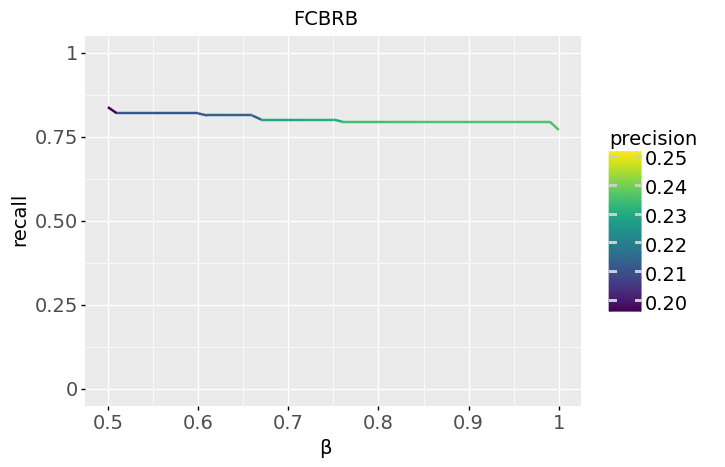

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/fcbrb_beta.png


In [61]:
dfBeta = dfBetaGamma[dfBetaGamma['gammaThreshold']==1.0]
grouped = dfBeta.groupby("betaThreshold")

resultRows = []
for beta,dfGrouped in grouped:
    precision,recall,f1 = getPRF("isInCBRB",dfGrouped)
    resultRows.append({'precision':precision,"recall":recall,"beta":beta})
resultDFBeta = pd.DataFrame(resultRows)

#precision,recall,threshold = precision_recall_curve(dfBeta['isSemanticRoleMatch'],dfBeta['betaThreshold'])

print(resultDFBeta)
#print(recall)
plot = ggplot(resultDFBeta,aes(x = 'beta',y='recall',color='precision')) + geom_line(size=1.0) + xlim(0.5,1) + ylim(0,1) + ggtitle("FCBRB") + xlab("β")+ theme(text=element_text(size=14))#+ theme(axis_text_x = element_text(angle=90, hjust=1))

print(plot)
plot.save("exportedPlots/fcbrb_beta.png")

# VA vs DA

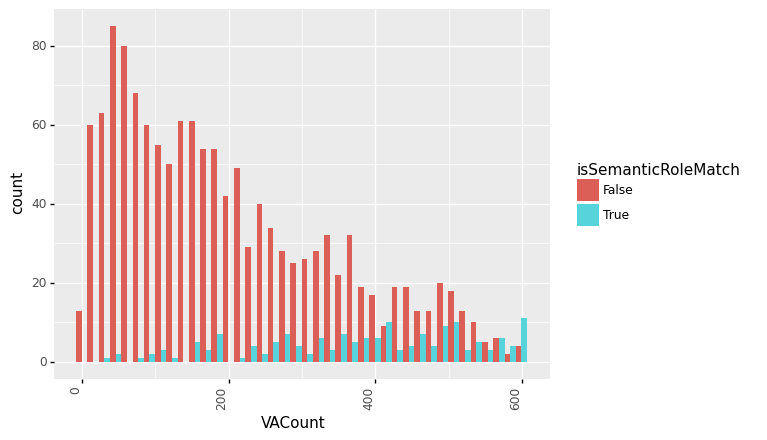

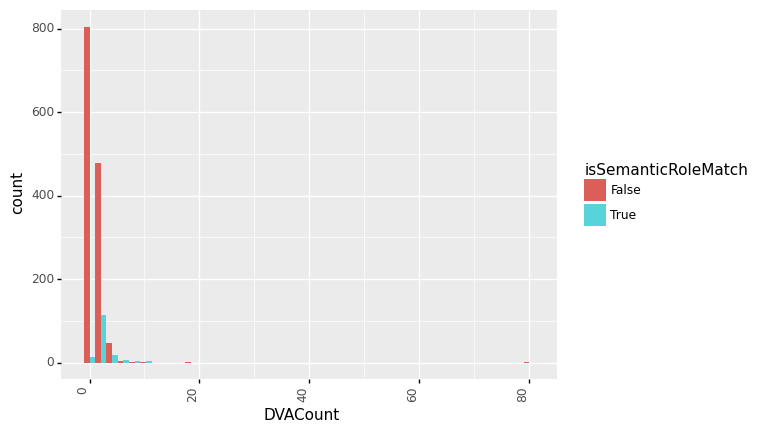

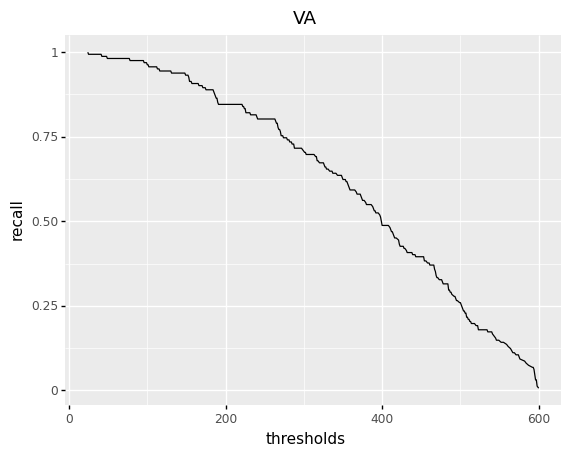

/usr/local/lib/python3.8/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 8 rows containing missing values.


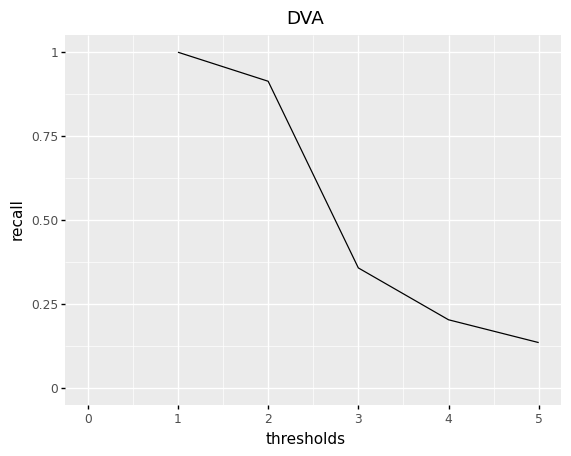

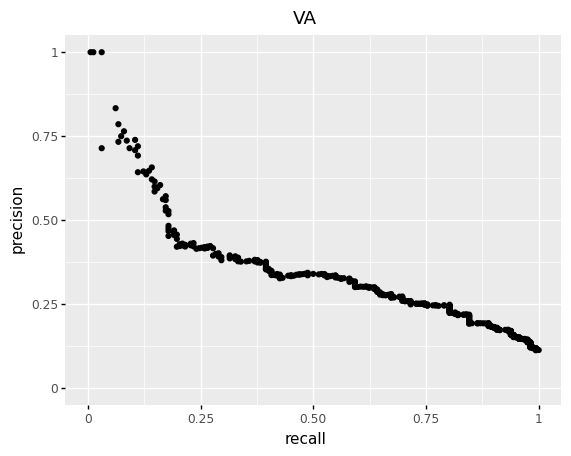

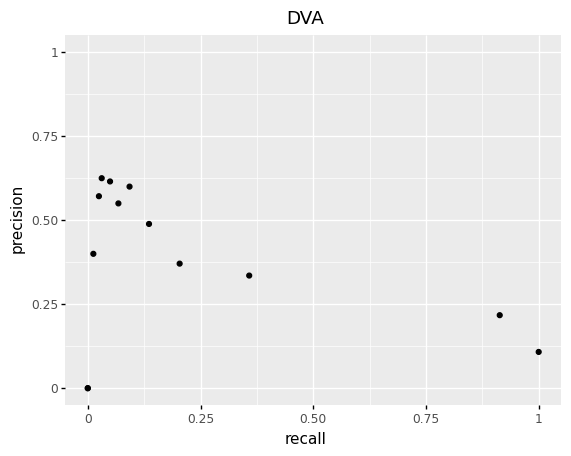


tv_and_film 0.918918918918919 125
education 0.9047619047619048 104
football 1.0 143
politics 0.7941176470588235 127
military 0.8095238095238095 136
all 0.9012345679012346 635


In [77]:
#print(df.columns)
plot = ggplot(df,aes(x = 'VACount',fill="isSemanticRoleMatch")) + geom_histogram(bins=40,position=position_dodge()) + theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)
plot = ggplot(df,aes(x = 'DVACount',fill="isSemanticRoleMatch")) + geom_histogram(bins=40,position=position_dodge()) + theme(axis_text_x = element_text(angle=90, hjust=1))
print(plot)
precision,recall,thresholds = precision_recall_curve(df['isSemanticRoleMatch'],df['VACount'])
plotDFVA = pd.DataFrame({'precision': precision[0:len(thresholds)], 'recall': recall[0:len(thresholds)], 'thresholds':thresholds})
precision,recall,thresholds = precision_recall_curve(df['isSemanticRoleMatch'],df['DVACount'])
plotDFDVA = pd.DataFrame({'precision': precision[0:len(thresholds)], 'recall': recall[0:len(thresholds)], 'thresholds':thresholds})
#print(plotDFVA)
plot = ggplot(plotDFVA, aes(x ='thresholds', y='recall')) + geom_line() + ggtitle("VA")
print(plot)
plot = ggplot(plotDFDVA, aes(x ='thresholds', y='recall')) + geom_line()  + ggtitle("DVA") + xlim(0,5)
print(plot)
#pr-curve
plot = ggplot(plotDFVA, aes(x ='recall', y='precision')) + geom_point() + ggtitle("VA") + ylim(0,1) + xlim(0,1)
print(plot)
plot = ggplot(plotDFDVA, aes(x ='recall', y='precision')) + geom_point()  + ggtitle("DVA") + ylim(0,1) + xlim(0,1)
print(plot)

#new filter:
df['VAandDVAFilter'] = ((df['VACount']>=95) & (df['DVACount']>=2))
for ds in df['dataset'].unique():
    p,r,f1,n = getPRFN('VAandDVAFilter',df[df['dataset']==ds])
    print(ds,r,n)
p,r,f1,n = getPRFN('VAandDVAFilter',df)
print("all",r,n)

# Result Set size

In [2]:
import glob
import os
import pandas as pd




dfAllPairsSample = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/home/leon/data/dataset_versioning/finalExperiments/allPairsSample/csvFiles/*.csv"))))

methodNames = ["isInExactMatchBlocking","isInSequenceBlocking","isInValueSetBlocking","isInStrictBlockingNoDecay","isInDVA2VA95Blocking",
               "isIncbrbWithOutDecayTargetRecall95","isRMTargetRecall95","isIncbrbWithDecayTargetRecall95",
               "isInTSMBlockingNoWildcard","isInTSMBlockingWithWildcard","isSCBTargetRecall95"]


rm.addFilteredBlockingMethods(dfAllPairsSample)
rm.addDVA2VA95Blocking(dfAllPairsSample)
rm.addParametrizedScoresAsBooleanScores(dfAllPairsSample)
print(dfAllPairsSample.columns)
groupedByDS = dfAllPairsSample.groupby("dataset")


Index(['dataset', 'id1', 'id2', 'isInStrictBlockingDecay',
       'isInStrictBlockingNoDecay', 'isInValueSetBlocking',
       'isInSequenceBlocking', 'isInExactMatchBlocking', 'isSemanticRoleMatch',
       'compatibilityPercentageDecay', 'compatibilityPercentageNoDecay',
       'exactSequenceMatchPercentage', 'hasTransitionOverlapNoDecay',
       'hasTransitionOverlapDecay', 'hasValueSetOverlap',
       'isInSVABlockingNoDecay', 'isInSVABlockingDecay', 'VACount', 'DVACount',
       'isInTSMBlockingNoWildcard', 'isInTSMBlockingWithWildcard',
       'strictlyCompatiblePercentage', 'strictlyCompatiblePercentageWithDecay',
       'isInDVA2VA95Blocking', 'isIncbrbWithDecayTargetRecall95',
       'isIncbrbWithOutDecayTargetRecall95', 'isRMTargetRecall95',
       'isSCBTargetRecall95', 'isSCBWithDecayTargetRecall95'],
      dtype='object')


In [36]:
#largeSampleDF['isInDVA2VA95Blocking'].describe()

mhm.printForReductionRatioForMethodNames(methodNames, groupedByDS)
mhm.printReductionRateForAllMethods("all",dfAllPairsSample,methodNames)

military isInExactMatchBlocking 41 / 856449 ( 99.99521279142132 %)
military isInSequenceBlocking 827 / 856449 ( 99.90343850013252 %)
military isInValueSetBlocking 1668 / 856449 ( 99.80524234367721 %)
military isInStrictBlockingNoDecay 1200 / 856449 ( 99.85988657818504 %)
military isInDVA2VA95Blocking 5604 / 856449 ( 99.34567032012413 %)
military isInStrictBlockingNoDecayWithFilter 563 / 856449 ( 99.93426345293182 %)
military isInValueSetBlockingWithFilter 1364 / 856449 ( 99.84073774387033 %)
military isInSequenceBlockingWithFilter 727 / 856449 ( 99.91511461861711 %)
military isInExactMatchBlockingWithFilter 38 / 856449 ( 99.99556307497586 %)
military isIncbrbWithOutDecayTargetRecall95 76740 / 856449 ( 91.03974667493335 %)
military isRMTargetRecall95 25526 / 856449 ( 97.01955399562613 %)
military isIncbrbWithDecayTargetRecall95 150700 / 856449 ( 82.40408944373804 %)
military isInTSMBlockingNoWildcard 1494 / 856449 ( 99.82555878984037 %)
military isInTSMBlockingWithWildcard 688 / 856449 

In [29]:
rm.addParametrizedScoresAsBooleanScores(largeSampleDF)
rm.addFilteredBlockingMethods(largeSampleDF)
rm.addDVA2VA95Blocking(largeSampleDF)
groupedByDSDVASample = largeSampleDF.groupby('dataset')
print(len(largeSampleDF.index))
mhm.printForReductionRatioForMethodNames(methodNames,groupedByDSDVASample)
mhm.printReductionRateForAllMethods("all",largeSampleDF,methodNames)

50000
education isInExactMatchBlocking 268 / 10000 ( 2.68 %)
education isInSequenceBlocking 2219 / 10000 ( 22.19 %)
education isInValueSetBlocking 4235 / 10000 ( 42.35 %)
education isInStrictBlockingNoDecay 1265 / 10000 ( 12.65 %)
education isInDVA2VA95Blocking 10000 / 10000 ( 100.0 %)
education isInStrictBlockingNoDecayWithFilter 1145 / 10000 ( 11.45 %)
education isInValueSetBlockingWithFilter 3723 / 10000 ( 37.23 %)
education isInSequenceBlockingWithFilter 1933 / 10000 ( 19.33 %)
education isInExactMatchBlockingWithFilter 201 / 10000 ( 2.01 %)
education isIncbrbWithOutDecayTargetRecall95 4895 / 10000 ( 48.95 %)
education isRMTargetRecall95 5033 / 10000 ( 50.33 %)
education isIncbrbWithDecayTargetRecall95 5258 / 10000 ( 52.58 %)
education isInTSMBlockingNoWildcard 3491 / 10000 ( 34.91 %)
education isInTSMBlockingWithWildcard 1776 / 10000 ( 17.76 %)
education isSCBTargetRecall95 4274 / 10000 ( 42.74 %)
football isInExactMatchBlocking 88 / 10000 ( 0.88 %)
football isInSequenceBlocking 1

In [15]:
#Reduction rate computation for military:

#28.06.2022_17:19:23.480 [main] DEBUG d.h.r.e.s.SimpleAllPairSampler[75] - Finshed military with sample size:1000000 with misses: 88280922
#28.06.2022_19:24:35.140 [main] DEBUG d.h.r.e.s.SimpleAllPairSampler[75] - Finshed politics with sample size:1000000 with misses: 41041877
#28.06.2022_21:54:55.369 [main] DEBUG d.h.r.e.s.SimpleAllPairSampler[75] - Finshed football with sample size:1000000 with misses: 38466606
#29.06.2022_00:40:12.254 [main] DEBUG d.h.r.e.s.SimpleAllPairSampler[75] - Finshed tv_and_film with sample size:1000000 with misses: 50646743
#29.06.2022_03:16:43.917 [main] DEBUG d.h.r.e.s.SimpleAllPairSampler[75] - Finshed education with sample size:1000000 with misses: 28997770

dsToAllPairs = {
    "military": {"allPairs":4263199291,"nMissesSVA":88280922,"nHitsSVA":1000000},
    "tv_and_film": {"allPairs":23657801481,"nMissesSVA":50646743,"nHitsSVA":1000000},
    "politics": {"allPairs":2223411270,"nMissesSVA":41041877,"nHitsSVA":1000000},
    "education": {"allPairs":2737889001,"nMissesSVA":28997770,"nHitsSVA":1000000},
    "football": {"allPairs":53116323211,"nMissesSVA":38466606,"nHitsSVA":1000000},
}

methodNames=["isInExactMatchBlocking","isInSequenceBlocking","isInValueSetBlocking","isInTSMBlockingNoWildcard","isInStrictBlockingNoDecay",
               "isRMTargetRecall95","isIncbrbWithOutDecayTargetRecall95","isIncbrbWithDecayTargetRecall95"]
print("dataset","#Total Pairs","#Total 1VA","EM,,","CSM,,","VSM,,","TSM (NWC),,","FCBRM (ND),,","RM ,,","CBRB (ND),,","CBRB (D),,",sep=",")
print(",," + (",N (AP),RRAP,RR 1VA"* (len(methodNames))))
for (ds,thisDsAllPairsSample) in groupedByDS:
    #print("--------------------------------------------------------------------")

    #print("--------------------------------------------------------------------")
    #thisDsAllPairsSample = dfAllPairsSample[dfAllPairsSample['dataset']==ds]
    nAllPairs = dsToAllPairs[ds]["allPairs"]
    nHitsSVA = dsToAllPairs[ds]["nHitsSVA"]
    nMissesSVA = dsToAllPairs[ds]["nMissesSVA"]
    estimatedCountSVAPairs = round((nHitsSVA / (nHitsSVA+nMissesSVA)) * nAllPairs)
    nHits90VA2DA = len(thisDsAllPairsSample[thisDsAllPairsSample['isInDVA2VA95Blocking']].index)
    nMisses90VA2DA = len(thisDsAllPairsSample[thisDsAllPairsSample['isInDVA2VA95Blocking']].index)
    #printReductionRate("AllPairs","SVA",nHitsSVA,nMissesSVA,nAllPairs)
    print(ds,nAllPairs,estimatedCountSVAPairs,sep=",",end=",")
    for method in methodNames:
        thisDF = thisDsAllPairsSample[thisDsAllPairsSample[method]]
        nHitsThisMethod = len(thisDF.index)
        nMissesThisMethod = nMissesSVA + len(thisDsAllPairsSample) - nHitsThisMethod
        n,rrAll = mhm.getReductionRate(nHitsThisMethod,nMissesThisMethod,nAllPairs)
        _,rr1VA = mhm.getReductionRate(nHitsThisMethod,len(thisDsAllPairsSample) - nHitsThisMethod,estimatedCountSVAPairs)
        rr95 = mhm.getReductionRateToOtherMethod(method,"isInDVA2VA95Blocking",thisDsAllPairsSample)
        print(round(n),rrAll,rr1VA,sep=",",end=",")
    print("")
        # printReductionRate("All Pairs",method,nHitsThisMethod,len(thisDsAllPairsSample) - nHitsThisMethod,nAllPairs)
        # printReductionRate("SVA",method,nHitsThisMethod,len(thisDsAllPairsSample) - nHitsThisMethod,estimatedCountSVAPairs)
        # printReductionRateToOtherMethod(method,"isInDVA2VA95Blocking",thisDsAllPairsSample)

dataset,#Total Pairs,#Total 1VA,EM,,,CSM,,,VSM,,,TSM (NWC),,,FCBRM (ND),,,RM ,,,CBRB (ND),,,CBRB (D),,
,,,N (AP),RRAP,RR 1VA,N (AP),RRAP,RR 1VA,N (AP),RRAP,RR 1VA,N (AP),RRAP,RR 1VA,N (AP),RRAP,RR 1VA,N (AP),RRAP,RR 1VA,N (AP),RRAP,RR 1VA,N (AP),RRAP,RR 1VA
education,2737889001,91269751,821,0.9999996999776983,0.999991,9583,0.999996499739814,0.999895,29024,0.9999893992120081,0.999682,16063,0.9999941328972121,0.999824,217496,0.9999205607616832,0.997617,3702266,0.9986477661506172,0.959436,12377182,0.9954792972944322,0.864389,18784410,0.9931390900056905,0.794188,
football,53116323211,1345854853,21534,0.9999995945939715,0.999984,2232773,0.9999579644624116,0.998341,5068489,0.9999045775560229,0.996234,2908392,0.9999452448482649,0.997839,1532929,0.9999711401583404,0.998861,87266575,0.9983570667313019,0.935159,373266114,0.9929726665627138,0.722655,502536819,0.9905389381595164,0.6266039999999999,
military,4263199291,47750395,2340,0.9999994511705423,0.999951,46222,0.9999891578180611,0.999032,9297